#### Introdução

Este Jupyter Notebook contém análises de influências relativas a parâmetros do processo de eletrofiação de nanofibras no diâmetro das nanofibras geradas com o copolímero poly(3-hydroxybutyrate-co-3-hydroxyhexanoate) – PHBHHx.

#### Definição de Métodos Utilizados nas Análises

In [1]:
# Importa pacotes e configura comportamentos gerais para este notebook
#
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import kruskal
from scikit_posthocs import posthoc_dunn
from statistics import mean

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Define constantes básicas para este notebook como um todo
#
DIRETORIO_DADOS = "dados"
NUM_MEDIDAS_POR_EXPERIMENTO = 45
NUM_VALORES_POR_PARAMETRO = 3
NUM_PARAMETROS = 4
NUM_MEDIDAS_POR_SERIE = NUM_MEDIDAS_POR_EXPERIMENTO * NUM_VALORES_POR_PARAMETRO ** (
    NUM_PARAMETROS - 1
)
DIAMETRO = "Length"
PROPRIEDADE = "Diâmetro [micrometro]"
PARAMETROS = {
    "C": "Concentração [%p/v]",
    "F": "Fluxo [mL/h]",
    "D": "Distância [cm]",
    "V": "Voltagem [kV]",
}
VALORES_PARAMETROS = {
    "C": ["8 %", "10 %", "12 %"],
    "F": ["0,2 mL/h", "0,5 mL/h", "0,8 mL/h"],
    "D": ["15 cm", "17,5 cm", "20 cm"],
    "V": ["15 kV", "20 kV", "25 kV"],
}
SIGLAS_PARAMETROS = list(PARAMETROS.keys())
FIGSIZE = (6, 3)
FIGSIZE_MAIOR = (9, 5)
DEBUG = False
ALPHA = 0.05

In [3]:
# Retorna lista com nomes de todos os arquivos CSV em certo diretório
#
def carregue_nomes_arquivos_csv(diretorio):
    return glob.glob(os.path.join(diretorio, "*.csv"))

In [4]:
# Retorna lista com nomes de arquivos CSV que contêm certa string
#
def filtre_nomes_arquivos_csv(arquivos_csv, string):
    lista_filtrada = []
    for arquivo in arquivos_csv:
        if string in arquivo:
            lista_filtrada = lista_filtrada + [arquivo]
    if DEBUG:
        print("Lista filtrada com {} arquivos:".format(len(lista_filtrada)))
        print(*lista_filtrada, sep="\n")
    return lista_filtrada

In [5]:
# Retorna lista com os primeiros NUM_MEDIDAS_POR_EXPERIMENTO diâmetros
# contidos em certo arquivo CSV
#
def carregue_propriedades_de_arquivo(arquivo):
    # Carrega os diâmetros contidos no arquivo
    df = pd.read_csv(arquivo)
    propriedades = list(df[DIAMETRO].head(NUM_MEDIDAS_POR_EXPERIMENTO))
    if DEBUG:
        print("# propriedades carregados de {}: {}".format(arquivo, len(propriedades)))
    return propriedades

In [6]:
# Retorna lista com os primeiros NUM_MEDIDAS_POR_EXPERIMENTO diâmetros
# contidos em certos arquivos CSV
#
def carregue_propriedades_de_arquivos(arquivos):
    propriedades = []
    for arquivo in arquivos:
        propriedades = propriedades + carregue_propriedades_de_arquivo(arquivo)
    return propriedades

In [7]:
# Retorna DataFrame com os primeiros NUM_MEDIDAS_POR_EXPERIMENTO
# diâmetros contidos em arquivos CSV. São incluídos na coluna i do
# DataFrame apenas diâmetros de arquivos CSV cujos nomes têm certa
# sigla que revela certo parâmetro e foram gerados com o i-esimo
# valor atribuído a esse parâmetro
#
def carregue_propriedades_de_arquivos_por_param(arquivos, sigla_parametro):
    valores_parametros = VALORES_PARAMETROS[sigla_parametro]
    df = pd.DataFrame(
        columns=valores_parametros, index=np.arange(NUM_MEDIDAS_POR_SERIE)
    )
    valor_parametro_1 = valores_parametros[0]
    valor_parametro_2 = valores_parametros[1]
    valor_parametro_3 = valores_parametros[2]
    df[valor_parametro_1] = pd.Series(
        carregue_propriedades_de_arquivos(
            filtre_nomes_arquivos_csv(arquivos, sigla_parametro + "1")
        )
    )
    df[valor_parametro_2] = pd.Series(
        carregue_propriedades_de_arquivos(
            filtre_nomes_arquivos_csv(arquivos, sigla_parametro + "2")
        )
    )
    df[valor_parametro_3] = pd.Series(
        carregue_propriedades_de_arquivos(
            filtre_nomes_arquivos_csv(arquivos, sigla_parametro + "3")
        )
    )
    return df

In [8]:
# Plota boxplot com séries de diâmetros gerados com cada valor atribuído
# a certo parâmetro
# Teoria: Boxplot é uma representação gráfica não paramétrica que resume a
# distribuição de dados quantitativos, mostrando a mediana, quartis e
# outliers (se desejável)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html
#
def crie_boxplot_por_param(df, sigla_parametro, propriedade):
    plt.figure(figsize=FIGSIZE)
    bp = df.boxplot(showfliers=False, return_type="dict")
    ax = plt.gca()
    for i, median_line in enumerate(bp["medians"]):
        x, y = median_line.get_xdata(), median_line.get_ydata()
        median_value = y[0]
        ax.text(
            np.mean(x),
            median_value,
            f"{median_value:.3f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=9,
        )
    plt.title("Boxplot: {} x {}".format(propriedade, PARAMETROS[sigla_parametro]))
    plt.xticks(rotation=45)
    plt.ylabel(propriedade)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [9]:
# Plota Kernel Density Estimation (KDE) com séries  de diâmetros gerados com cada
# valor atribuído a certo parâmetro
# Teoria: KDE é um método não paramétrico que estima Probability Density Function (PDF)
# Ref 1: https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot
# Ref 2: https://towardsdatascience.com/kernel-density-estimation-explained-step-by-step-7cc5b5bc4517/
#
def crie_kde_por_param(df, sigla_parametro, propriedade):
    plt.figure(figsize=FIGSIZE)
    sns.kdeplot(data=df.iloc[:, 0], label=df.columns[0], alpha=0.1, fill=True)
    sns.kdeplot(data=df.iloc[:, 1], label=df.columns[1], alpha=0.1, fill=True)
    sns.kdeplot(data=df.iloc[:, 2], label=df.columns[2], alpha=0.1, fill=True)
    plt.title("KDE: {} x {}".format(propriedade, PARAMETROS[sigla_parametro]))
    plt.xlabel(propriedade, fontsize=10)
    plt.ylabel("Densidade", fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [10]:
# Aplica Teste H de Kruskal-Wallis nas séries (grupos) de diâmetros gerados com cada valor
# atribuído a certo parâmetro
# Teoria: Teste H de Kruskal-Wallis é um método estatístico não paramétrico utilizado para
# detectar diferenças entre 3 ou mais grupos independentes
# Ref 1: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.kruskalwallis.html
# Ref 2: https://www.blog.psicometriaonline.com.br/teste-de-kruskal-wallis/
#
def aplique_teste_kruskal_wallis(df):
    _, p_value = kruskal(*[df[col].values for col in df.columns])
    sig = "sim" if p_value < ALPHA else "não"
    print("Resultados do Teste H de Kruskal-Wallis:")
    print("\tP-value: {}".format(p_value))
    print("\tSignificativo (α < {}): {}".format(ALPHA, sig))

In [11]:
# Aplica Teste post hoc de Dunn nas séries de diâmetros gerados com cada valor atribuído
# a certo parâmetro
# Teoria: Teste post hoc de Dunn realiza comparações múltiplas de somas de classificações médias.
# Indicado ser utilizado após Teste H de Kruskal-Wallis
# Ref 1: https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
# Ref 2: https://www.blog.psicometriaonline.com.br/o-que-e-um-teste-post-hoc/
#
def aplique_teste_posthoc_dunn(df):
    g1 = df.iloc[:, 0].values
    g2 = df.iloc[:, 1].values
    g3 = df.iloc[:, 2].values
    dunn_results = posthoc_dunn([g1, g2, g3], p_adjust="holm")
    plt.figure(figsize=FIGSIZE)
    mask = np.triu(np.ones_like(dunn_results, dtype=bool))
    sns.heatmap(
        dunn_results,
        annot=True,
        cmap="RdYlBu",
        mask=mask,
        vmin=0,
        vmax=1,
        center=0.5,
        xticklabels=df.columns,
        yticklabels=df.columns,
    )
    plt.title("Resultados do Teste post hoc de Dunn (P-values)")
    plt.tight_layout()
    plt.show()

In [12]:
# Realiza estudo sobre certo parâmetro e retorna o DataFrame carregado
#
def realize_estudo_por_param(arquivos, sigla_parametro, propriedade):
    df = carregue_propriedades_de_arquivos_por_param(arquivos, sigla_parametro)
    print("Estatísticas gerais relativas aos diâmetros considerados:")
    display(pd.melt(df).describe())
    print("Estatísticas estratificadas relativas aos diâmetros considerados:")
    display(df.describe())
    crie_boxplot_por_param(df, sigla_parametro, propriedade)
    crie_kde_por_param(df, sigla_parametro, propriedade)
    aplique_teste_kruskal_wallis(df)
    aplique_teste_posthoc_dunn(df)
    return df

#### Carregamento dos Arquivos com Dados Utilizados na Análises

In [13]:
# Carrega nomes de todos os arquivos CSV em DIRETORIO_DADOS
#
ARQUIVOS_CSV = carregue_nomes_arquivos_csv(DIRETORIO_DADOS)

#### 1ª Análise: Influência do 1o Parâmetro (Concentração) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (concentração) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que algum valor de concentração tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Concentração de 8% tende a resultar diâmetros diferentes de 10% e 12%;
    * Concentração de 10% tende a resultar diâmetros diferentes de 12%.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,8 %,10 %,12 %
count,1215.000000,1215.000000,1215.000000
mean,2.905578,2.743295,3.181787
std,0.913389,0.844380,0.971826
min,0.497000,0.666000,1.093000
25%,2.275000,2.113000,2.450000
50%,2.906000,2.706000,3.022000
75%,3.511000,3.243000,3.686000
max,6.790000,6.511000,7.881000


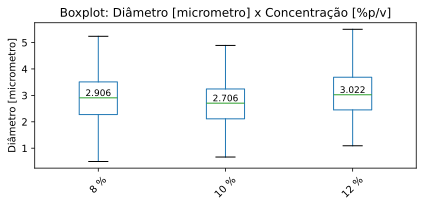

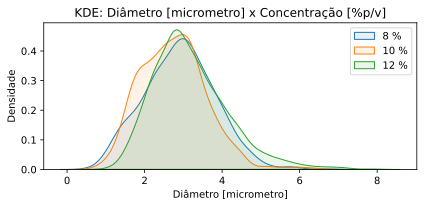

Resultados do Teste H de Kruskal-Wallis:
	P-value: 1.6090292273459535e-24
	Significativo (α < 0.05): sim


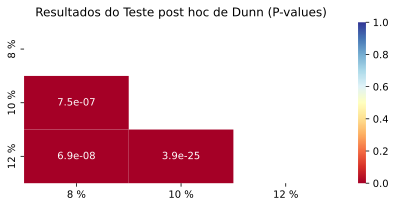

In [14]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[0]
df_estudo_1 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)

#### 2ª Análise: Influência do 2o Parâmetro (Fluxo) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (fluxo) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que algum valor de fluxo tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Fluxo de 0,2 mL/h tende a resultar diâmetros diferentes de 0,8 mL/h;
    * Fluxo de 0,2 mL/h tende a **NÃO** resultar diâmetros diferentes de 0,5 mL/h;
    * Fluxo de 0,5 mL/h tende a resultar diâmetros diferentes de 0,8 mL/h.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,"0,2 mL/h","0,5 mL/h","0,8 mL/h"
count,1215.000000,1215.000000,1215.000000
mean,2.962021,3.012972,2.855666
std,0.928607,0.961207,0.889361
min,0.666000,0.497000,1.103000
25%,2.329500,2.367000,2.227000
50%,2.953000,2.943000,2.747000
75%,3.532000,3.504000,3.338000
max,7.881000,7.125000,7.223000


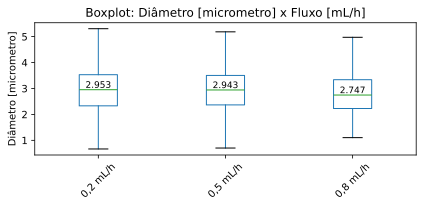

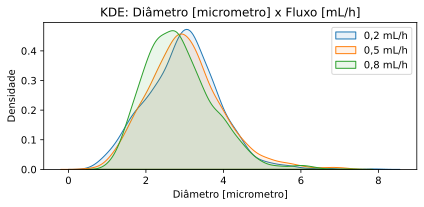

Resultados do Teste H de Kruskal-Wallis:
	P-value: 1.0262589442822639e-05
	Significativo (α < 0.05): sim


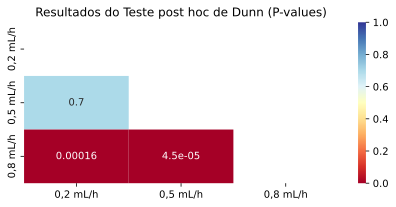

In [15]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[1]
df_estudo_2 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)

#### 3ª Análise: Influência do 3o Parâmetro (Distância) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (distância) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que **NENHUM** valor de distância tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Distância de 15 cm tende a **NÃO** resultar diâmetros diferentes de 17,5 cm;
    * Distância de 15 cm tende a **NÃO** resultar diâmetros diferentes de 20 cm;
    * Distância de 17,5 cm tende a **NÃO** resultar diâmetros diferentes de 20 cm.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,15 cm,"17,5 cm",20 cm
count,1215.000000,1215.000000,1215.000000
mean,2.917756,2.958981,2.953922
std,0.942686,0.926915,0.917195
min,0.772000,0.981000,0.497000
25%,2.231000,2.319500,2.319000
50%,2.840000,2.904000,2.904000
75%,3.504000,3.499000,3.476000
max,7.125000,7.104000,7.881000


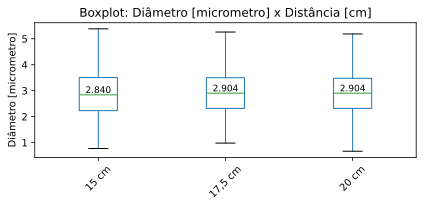

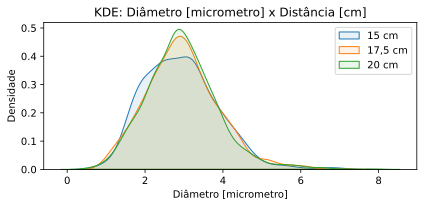

Resultados do Teste H de Kruskal-Wallis:
	P-value: 0.34728094559719697
	Significativo (α < 0.05): não


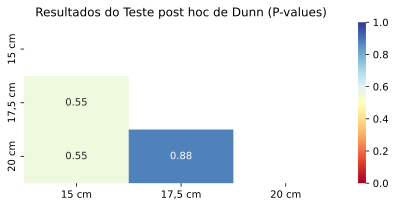

In [16]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[2]
df_estudo_3 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)

#### 4ª Análise: Influência do 4o Parâmetro (Voltagem) no Diâmetro

**Conclusões**

1. Não há evidência de que este parâmetro (voltagem) e esta propriedade (diâmetro) são linearmente dependentes;
1. O Teste H de Kruskal-Wallis indica que algum valor de voltagem tende a resultar diâmetros diferentes dos demais;
1. O Teste post hoc de Dunn indica que:
    * Voltagem de 15 kV tende a resultar diâmetros diferentes de 20 kV e 25 kV;
    * Voltagem de 20 kV tende a resultar diâmetros diferentes de 25 kV.

Estatísticas gerais relativas aos diâmetros considerados:


,value
count,3645.000000
mean,2.943553
std,0.928918
min,0.497000
25%,2.278000
50%,2.892000
75%,3.499000
max,7.881000


Estatísticas estratificadas relativas aos diâmetros considerados:


,15 kV,20 kV,25 kV
count,1215.000000,1215.000000,1215.000000
mean,3.101477,2.721698,3.007485
std,0.891221,0.865713,0.983891
min,0.772000,0.497000,0.832000
25%,2.533500,2.012000,2.325000
50%,3.094000,2.732000,2.904000
75%,3.563000,3.322000,3.563000
max,7.881000,6.595000,7.223000


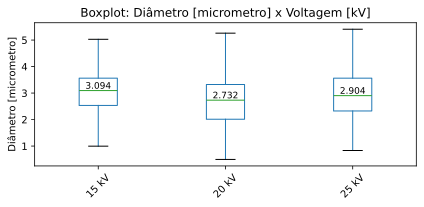

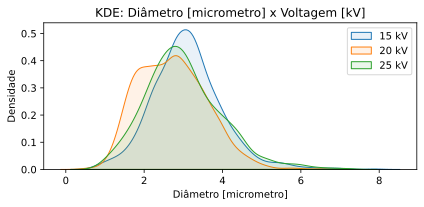

Resultados do Teste H de Kruskal-Wallis:
	P-value: 1.9654998271964068e-25
	Significativo (α < 0.05): sim


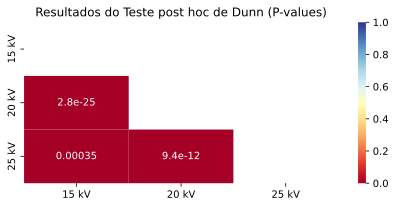

In [17]:
# Recupera a sigla referente ao parâmetro e, então, realiza o seu estudo
#
sigla_parametro = SIGLAS_PARAMETROS[3]
df_estudo_4 = realize_estudo_por_param(ARQUIVOS_CSV, sigla_parametro, PROPRIEDADE)